**Tutorial for gravitational-wave surrogate models**

Nikolaos Stergioulas, Paraskevi Nousi

Aristotle University of Thessaloniki


###### Content provided under a Creative Commons Attribution license, [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/); code under [GNU GPLv3 License](https://choosealicense.com/licenses/gpl-3.0/). (c)2023 [Nikolaos Stergioulas](http://www.astro.auth.gr/~niksterg/), [Paraskevi Nousi](https://www.researchgate.net/profile/Paraskevi-Nousi)

In [ ]:
# -- For google colab
! pip install -q pycbc 
! pip install -q forked-rompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
from pycbc.waveform import get_td_waveform
import tqdm
import sys 
import numpy as np
import matplotlib.pyplot as plt
import rompy as rp
from scipy.interpolate import PchipInterpolator
from scipy import optimize

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)

In [ ]:
# auxiliary functions
def Mq_to_m1m2(M, q):
  """Convert total mass, mass ratio pair to m1, m2"""
  m2 = M/(1.+q)
  m1 = M-m2
  return m1, m2

def common_time_grid(training_data, dt):
    """
    INPUT
    =====
    training_data: set of training waveforms

    OUTPUT
    ======
    training data as a numpy array, padding with zeros as
    necessary such that all waveforms are of the same length"""

    longest_waveform = 0
    for h in training_data:
        length = len(h)
        if length > longest_waveform:
            longest_waveform = length

    # print("longest waveform size = %i" % longest_waveform)

    padded_training_data = []
    for h in training_data:
        nZeros = longest_waveform - len(h)
        h_pad = np.append(h, np.zeros(nZeros))
        padded_training_data.append(h_pad)

    times = np.arange(longest_waveform) * dt

    padded_training_data = np.vstack(padded_training_data).transpose()

    return times, padded_training_data

def get_peak(t, h):
    """Get argument and values of t and h at maximum value of |h| on a discrete grid. """
    arg = np.argmax(np.abs(h))
    return [arg, t[arg], h[arg]]

def get_peaks(times, training_set):
    """ Find the index of each waveform's peak in the entire training set. """
    time_peak_arg = []
    for i in range(training_set.shape[1]):
        [arg, t_peak, h_peak] = get_peak(times, training_set[:, i])  # i^th training sample
        time_peak_arg.append(arg)
        # print("Waveform %i with t_peak = %f" % (i, t_peak))
    print(time_peak_arg)
    return time_peak_arg

def align_peaks(times, training_set, dt):
    """ Peak align a set of waveforms. The shortest waveform is used as the reference
    one."""

    time_peak_arg = get_peaks(times, training_set)

    min_peak_time = min(time_peak_arg)
    aligned_training_set = []
    for i in range(training_set.shape[1]):
        offset = time_peak_arg[i] - min_peak_time
        # print("offset value of %i" % offset)
        h_aligned = training_set[offset:, i]
        aligned_training_set.append(h_aligned)

    t, training_data_aligned = common_time_grid(aligned_training_set, dt=dt)
    return min_peak_time, training_data_aligned

In [ ]:
def align_A_phi(times, training_A, training_phi, dt):
    """ Peak align a set of waveforms. The shortest waveform is used as the reference
    one."""

    time_peak_arg = get_peaks(times, training_A)

    min_peak_time = min(time_peak_arg)
    aligned_training_A = []
    aligned_training_phi = []

    for i in range(training_A.shape[1]):
        offset = time_peak_arg[i] - min_peak_time
        A_aligned = training_A[offset:, i]
        phi_aligned = training_phi[offset:, i]
        aligned_training_A.append(A_aligned)
        aligned_training_phi.append(phi_aligned)

    t, training_A_aligned = common_time_grid(aligned_training_A, dt=dt)
    t, training_phi_aligned = common_time_grid(aligned_training_phi, dt=dt)
    return min_peak_time, training_A_aligned, training_phi_aligned

In [ ]:
def training_set_generator(Mtot=60, nsample=20, q_min=1.0, q_max=8.0, s1=0.0,
                           s2=0.0, f_low=8.0, delta_t=1/2048, 
                           amplitude_scaling=1e18, sampling='random', 
                           verbose=False):

  if sampling == 'linear':
    lambda_values = np.linspace(q_min, q_max, nsample)
    lambda_values_sorted = lambda_values
  elif sampling == 'random':
    lambda_values = np.random.uniform(low=q_min, high=q_max, size=nsample)
    lambda_values_sorted = np.sort(lambda_values)

  training_hp = []
  training_hc = []

  for (q) in tqdm.tqdm(lambda_values_sorted):
    m1, m2 = Mq_to_m1m2(Mtot, q)
    hp, hc = get_td_waveform(approximant='SEOBNRv4',
                             mass1=m1,
                             mass2=m2,
                             spin1z=s1,
                             spin2z=s2,
                             delta_t=delta_t,
                             f_lower=f_low,
                             mode_array=[[2, 2]])
    
    hp = amplitude_scaling*hp
    hc = amplitude_scaling*hc

    training_hp.append(hp)
    training_hc.append(hc)

    if verbose:
      print('length of h is', len(hp))
  return lambda_values_sorted, training_hp, training_hc

###Constants and units. We use a dimensionless system of units defined by setting $c=G=M_\odot=1$.

In [ ]:
G = 6.67408e-11
c = 2.99792458e8
MSUN = 1.9891e30

#Time unit
TIME = G*MSUN/c**3

###REDUCED ORDER MODEL

Construct a template bank of waveforms with total mass $M_{\rm tot}$. 

In [ ]:
Mtot = 60

delta_t_init = 1.0/4096

print('delta_t =',delta_t_init)

delta_t = 0.000244140625


Choose the number of training samples, the range for $q, s_1, s_2$, the starting frequency $f_{\rm lower}$ and an amplitude scaling so that the maximum amplitude is of order unity. Generate the training set. The outpout for each polarization is a row-ordered matrix (each row is one waveform in Pycbc format). 

In [ ]:
nsample = 40
q_min = 1.0
q_max = 8.0
spin1z = 0.0 # nonspinning in this example
spin2z = 0.0 # nonspinning in this example
f_lower = 8.0
amplitude_scaling = 1e18

lambda_values, hp_ro_pycbc, hc_ro_pycbc = training_set_generator(Mtot, nsample, \
                                                  q_min, q_max, spin1z, spin2z, f_lower, delta_t_init, \
                                                  amplitude_scaling, sampling = 'random', verbose=True)

  2%|▎         | 1/40 [00:01<00:42,  1.10s/it]

length of h is 45186


  5%|▌         | 2/40 [00:02<00:40,  1.05s/it]

length of h is 45291


  8%|▊         | 3/40 [00:03<00:39,  1.08s/it]

length of h is 45354


 10%|█         | 4/40 [00:04<00:38,  1.06s/it]

length of h is 45541


 12%|█▎        | 5/40 [00:05<00:39,  1.13s/it]

length of h is 47306


 15%|█▌        | 6/40 [00:08<00:58,  1.73s/it]

length of h is 49034


 18%|█▊        | 7/40 [00:10<01:00,  1.82s/it]

length of h is 49122


 20%|██        | 8/40 [00:12<01:03,  2.00s/it]

length of h is 50703


 25%|██▌       | 10/40 [00:17<01:04,  2.15s/it]

length of h is 52330
length of h is 52885


 28%|██▊       | 11/40 [00:20<01:13,  2.54s/it]

length of h is 56586


 30%|███       | 12/40 [00:22<01:01,  2.20s/it]

length of h is 61408


 32%|███▎      | 13/40 [00:23<00:51,  1.90s/it]

length of h is 62509


 35%|███▌      | 14/40 [00:25<00:47,  1.83s/it]

length of h is 63581


 38%|███▊      | 15/40 [00:27<00:48,  1.93s/it]

length of h is 64006


 40%|████      | 16/40 [00:30<00:52,  2.21s/it]

length of h is 65907


 42%|████▎     | 17/40 [00:33<01:00,  2.63s/it]

length of h is 66509


 45%|████▌     | 18/40 [00:35<00:51,  2.35s/it]

length of h is 74903


 48%|████▊     | 19/40 [00:36<00:43,  2.07s/it]

length of h is 75203


 50%|█████     | 20/40 [00:38<00:37,  1.87s/it]

length of h is 76236


 52%|█████▎    | 21/40 [00:39<00:32,  1.72s/it]

length of h is 76771


 55%|█████▌    | 22/40 [00:40<00:29,  1.63s/it]

length of h is 77898


 57%|█████▊    | 23/40 [00:42<00:26,  1.57s/it]

length of h is 79564


 60%|██████    | 24/40 [00:44<00:25,  1.62s/it]

length of h is 80240


 62%|██████▎   | 25/40 [00:45<00:24,  1.66s/it]

length of h is 81307


 65%|██████▌   | 26/40 [00:47<00:22,  1.60s/it]

length of h is 82228


 68%|██████▊   | 27/40 [00:48<00:20,  1.55s/it]

length of h is 82303


 70%|███████   | 28/40 [00:50<00:18,  1.53s/it]

length of h is 82739


 72%|███████▎  | 29/40 [00:51<00:16,  1.51s/it]

length of h is 83664


 75%|███████▌  | 30/40 [00:53<00:15,  1.51s/it]

length of h is 87627


 78%|███████▊  | 31/40 [00:54<00:13,  1.52s/it]

length of h is 87856


 80%|████████  | 32/40 [00:56<00:13,  1.70s/it]

length of h is 93087


 82%|████████▎ | 33/40 [00:58<00:12,  1.72s/it]

length of h is 93234


 85%|████████▌ | 34/40 [01:00<00:10,  1.70s/it]

length of h is 93316


 88%|████████▊ | 35/40 [01:01<00:08,  1.68s/it]

length of h is 93607


 90%|█████████ | 36/40 [01:03<00:06,  1.67s/it]

length of h is 93706


 92%|█████████▎| 37/40 [01:05<00:05,  1.67s/it]

length of h is 96141


 95%|█████████▌| 38/40 [01:07<00:03,  1.69s/it]

length of h is 102950


 98%|█████████▊| 39/40 [01:09<00:01,  1.90s/it]

length of h is 104090


100%|██████████| 40/40 [01:11<00:00,  1.78s/it]

length of h is 105996


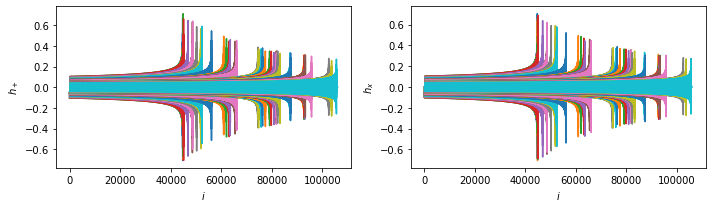

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(hp_ro_pycbc[i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$i$')
plt.ylabel('$h_+$')

plt.subplot(1, 2, 2)
[plt.plot(hc_ro_pycbc[i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$i$')
plt.ylabel('$h_x$')

plt.tight_layout()
plt.show()

Zero-padding waveforms to create a common time grid. For each polarization the output is a column-ordered matrix (each column is one waveform).

In [ ]:
times, hp_co_0pad = common_time_grid(hp_ro_pycbc, dt=delta_t_init)
times, hc_co_0pad = common_time_grid(hc_ro_pycbc, dt=delta_t_init)

In [ ]:
#no longer needed
del hp_ro_pycbc, hc_ro_pycbc

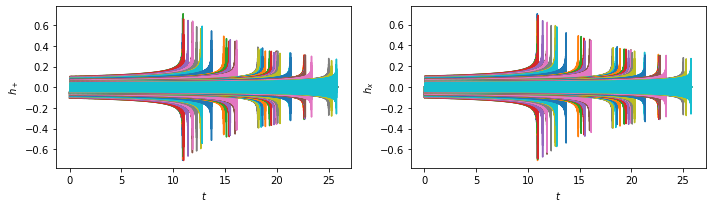

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(times, hp_co_0pad[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$h_+$')

plt.subplot(1, 2, 2)
[plt.plot(times, hc_co_0pad[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$h_x$')

plt.tight_layout()
plt.show()

###Compute Amplitude.

In [ ]:
A_co_0pad = np.sqrt(hp_co_0pad**2 + hc_co_0pad**2)


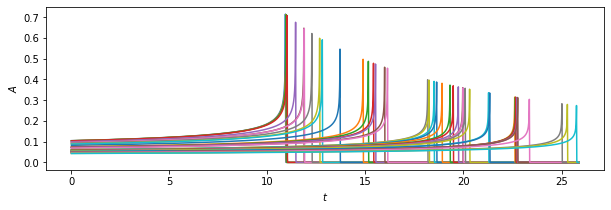

In [ ]:
[plt.plot(times, A_co_0pad[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

###Compute Phase, then unwrap the phase of each waveform. 

In [ ]:
phi_co_0pad = np.arctan2(-hc_co_0pad, hp_co_0pad)

In [ ]:
del hc_co_0pad, hp_co_0pad

In [ ]:
temp = phi_co_0pad[:,0]
phi_co_0pad_unwrap = np.unwrap(temp)

for i in range(1,lambda_values.shape[0]):
  temp = phi_co_0pad[:,i]
  temp_unwrap = np.unwrap(temp)
  phi_co_0pad_unwrap = (np.column_stack((phi_co_0pad_unwrap,temp_unwrap)))

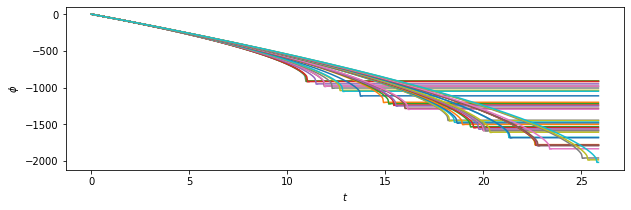

In [ ]:
[plt.plot(times,phi_co_0pad_unwrap[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

In [ ]:
display(phi_co_0pad_unwrap.shape, A_co_0pad.shape)

(105996, 40)

(105996, 40)

###Alignment



In [ ]:
time_align, A_co_aligned, phi_co_aligned = align_A_phi(times, A_co_0pad, phi_co_0pad_unwrap, delta_t_init)
display(time_align)

[44715, 44821, 44884, 45071, 46837, 48565, 48653, 50235, 51862, 52416, 56118, 60941, 62042, 63114, 63539, 65441, 66043, 74438, 74737, 75770, 76305, 77433, 79099, 79774, 80841, 81762, 81837, 82274, 83199, 87162, 87391, 92623, 92769, 92851, 93143, 93241, 95676, 102485, 103625, 105532]


44715

In [ ]:
del A_co_0pad, phi_co_0pad_unwrap

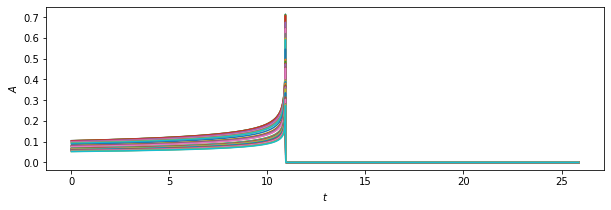

In [ ]:
[plt.plot(times, A_co_aligned[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

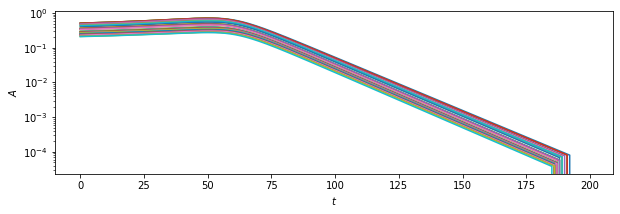

In [ ]:
[plt.plot(A_co_aligned[time_align-50:time_align+150,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.yscale('log')
plt.show()

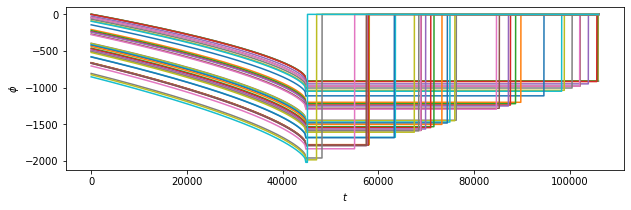

In [ ]:
[plt.plot(phi_co_aligned[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

###Trim zeros that were added by zero padding from both $A$ and $\phi$ and restrict time to $-20,000M$ before alignment to $100M$ after alignment.




In [ ]:
time_start = time_align - int(20000*Mtot*TIME/delta_t_init) 
time_trim = int(time_align + 100*Mtot*TIME/delta_t_init)
time_align_trim = time_align - time_start
time_end = int(time_align_trim + 100*Mtot*TIME/delta_t_init) # only inspiral part

display(time_start, time_trim, time_end, time_align_trim)

20498

44836

24338

24217

In [ ]:
A_co_aligned_trim =  A_co_aligned[time_start:time_trim,]
phi_co_aligned_trim =  phi_co_aligned[time_start:time_trim,]
times_trim = times[time_start:time_trim]
times_trim = times_trim - times_trim[0]

In [ ]:
del A_co_aligned, phi_co_aligned

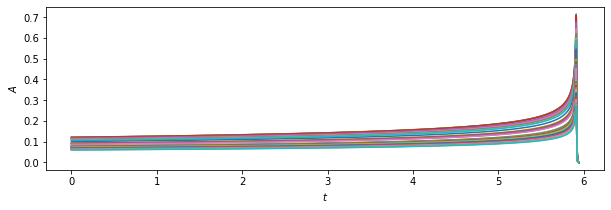

In [ ]:
[plt.plot(times_trim, A_co_aligned_trim[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

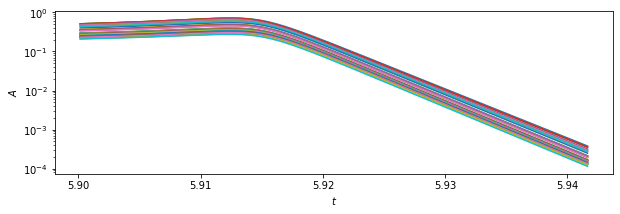

In [ ]:
[plt.semilogy(times_trim[time_align_trim-50:time_align_trim+150],A_co_aligned_trim[time_align_trim-50:time_align_trim+150,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

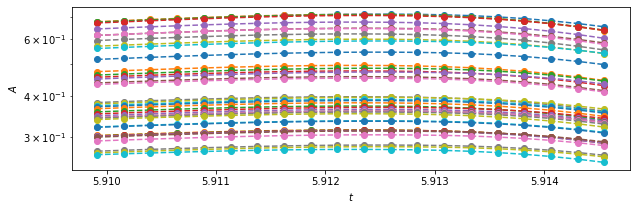

In [ ]:
[plt.semilogy(times_trim[time_align_trim-10:time_align_trim+10],A_co_aligned_trim[time_align_trim-10:time_align_trim+10,i], 'o--') for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

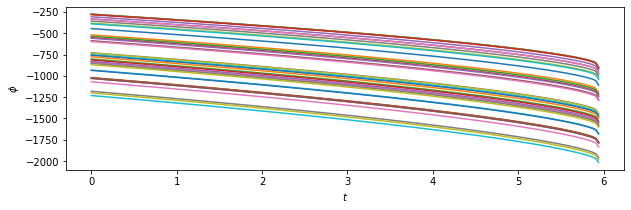

In [ ]:
[plt.plot(times_trim, phi_co_aligned_trim[:,i]) for i in range(lambda_values.shape[0])];

plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

###Shift phase vertically to common origin.

In [ ]:
phi_co_aligned_trim_vshift = phi_co_aligned_trim[:,0] - phi_co_aligned_trim[0,0]

for i in range(1,lambda_values.shape[0]):
  temp = phi_co_aligned_trim[:,i] - phi_co_aligned_trim[0,i]
  phi_co_aligned_trim_vshift = (np.column_stack((phi_co_aligned_trim_vshift,temp)))

In [ ]:
del phi_co_aligned_trim

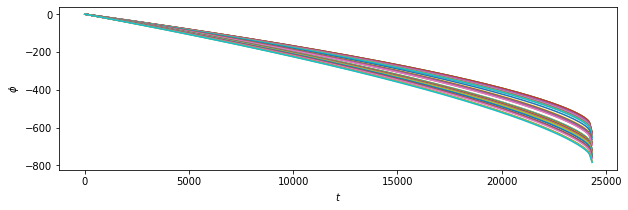

In [ ]:
[plt.plot(phi_co_aligned_trim_vshift[:,i]) for i in range(lambda_values.shape[0])];

plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

###ROM

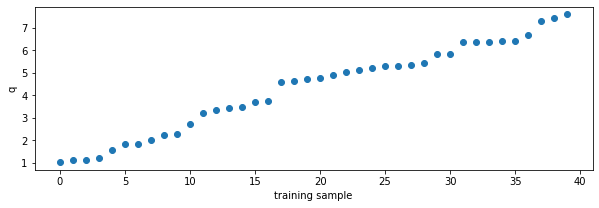

In [ ]:
plt.plot(lambda_values,'o');
plt.xlabel('training sample')
plt.ylabel('q')
plt.show()

Transpose to store training data in row-ordered format (each row is one waveform).

In [ ]:
A_ro = A_co_aligned_trim.transpose()
phi_ro = phi_co_aligned_trim_vshift.transpose()

In [ ]:
del A_co_aligned_trim, phi_co_aligned_trim_vshift

Define an integration rule for the given training set (choices are riemmann, trapezoidal, chebychev or chebychev-lobatto). 

In [ ]:
integration_A = rp.Integration([times_trim.min(), times_trim.max()], num=A_ro.shape[1], rule='trapezoidal')
integration_phi = rp.Integration([times_trim.min(), times_trim.max()], num=phi_ro.shape[1], rule='trapezoidal')

Construct the reduced basis, chosing a seed waveform and a maximum error.

>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.


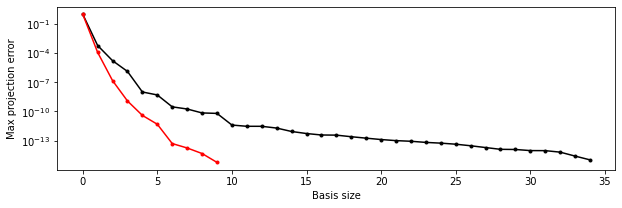

In [ ]:
rb_A = rp.ReducedBasis(integration_A)
rb_A.make(A_ro, 0, 1e-16, verbose=False)

rb_phi = rp.ReducedBasis(integration_phi)
rb_phi.make(phi_ro, 0, 1e-16, verbose=False)

plt.semilogy(rb_A.errors/rb_A.errors[0], 'k.-');
plt.semilogy(rb_phi.errors/rb_phi.errors[0], 'r.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

Here we show which $q_i$ contribute in constructing the reduced basis.

In [ ]:
display(rb_A.indices)

array([ 0, 39,  4, 14, 38,  9,  2, 22,  1, 11,  8,  7,  5,  3, 12, 29, 13,
       10,  6, 15, 17, 19, 23, 34, 16, 30, 20, 33, 18, 26, 37, 24, 31, 28,
       35], dtype=int32)

In [ ]:
display(rb_phi.indices)

array([ 0, 39, 14,  7, 30,  1,  4, 17,  9, 33], dtype=int32)

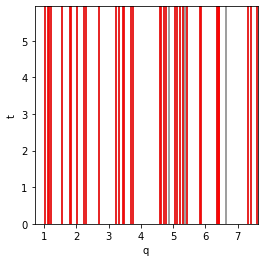

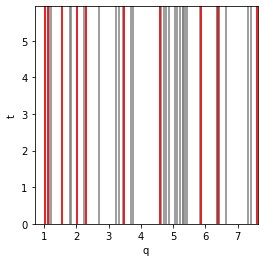

In [ ]:
fig1 = plt.figure(1, [4,4])
ax2 = fig1.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in lambda_values]
[ax2.axvline(x=nn, color='red') for nn in lambda_values[rb_A.indices]]
ax2.set_ylim(0,max(times_trim))
ax2.set_xlabel('q');
ax2.set_ylabel('t');
plt.show()

fig2 = plt.figure(2, [4,4])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in lambda_values]
[ax2.axvline(x=nn, color='red') for nn in lambda_values[rb_phi.indices]]
ax2.set_ylim(0,max(times_trim))
ax2.set_xlabel('q');
ax2.set_ylabel('t');

plt.show()

The $i-$th (out of a total of $M$) waveform in the training set is well approximated by the expansion
$$
h(t ; q_i) \approx \sum_{j=1}^{m} c_{ij} e_{j}(t), \ \ \ i=1,\ldots,M, \ \ \ j=1,\ldots,m,
$$
where
$$
c_{ij} =\left\langle h(t ; q_i), e_{j}(t)\right\rangle,
$$
are the coefficients of the expansion, which are elements of an $M\times m$ matrix. With $<\  , \, > $ we denote the orthogonal projection. 

Below, we plot all basis functions $e_j(t)$. Notice that these are reported by rompy without normalization to unity.


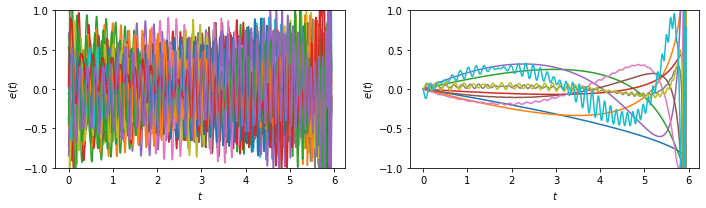

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim, rb_A.basis[j]) for j in range(rb_A.size)];
plt.xlabel('$t$')
plt.ylabel('$e(t)$')
plt.ylim(-1, 1)

plt.subplot(1, 2, 2)
[plt.plot(times_trim, rb_phi.basis[j]) for j in range(rb_phi.size)];
plt.xlabel('$t$')
plt.ylabel('$e(t)$')
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

All components of the basis seem to have a nearly common magnitude, equal to $1/\sqrt{\Delta t}$ up to numerical error.

In [ ]:
1/delta_t_init

4096.0

In [ ]:
magnitudes_A_squared = np.zeros(rb_A.size)
for j in range(rb_A.size): 
  magnitudes_A_squared[j] = np.dot(rb_A.basis[j],rb_A.basis[j]) 

magnitudes_phi_squared = np.zeros(rb_phi.size)
for j in range(rb_phi.size): 
  magnitudes_phi_squared[j] = np.dot(rb_phi.basis[j],rb_phi.basis[j]) 

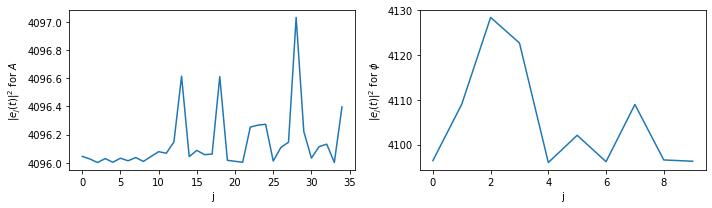

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(magnitudes_A_squared)
plt.xlabel('j')
plt.ylabel('$|e_j(t)|^2$ for $A$')

plt.subplot(1, 2, 2)
plt.plot(magnitudes_phi_squared)
plt.xlabel('j')
plt.ylabel('$|e_j(t)|^2$ for $\phi$')

plt.tight_layout()
plt.show()

The coefficients $c_{ij}$ are given by Rompy in transposed form as alpha[j][i] so we construct a new matrix in the right form.

In [ ]:
display(rb_A.alpha.shape)

(35, 40)

In [ ]:
rb_A_coeffs = rb_A.alpha.transpose()
rb_phi_coeffs = rb_phi.alpha.transpose()

For each sample $q_i$ in the training set we can plot the coefficients $c_{ij}$ as a function of the reduced basis index $j$. The coefficient of the first basis function dominates.

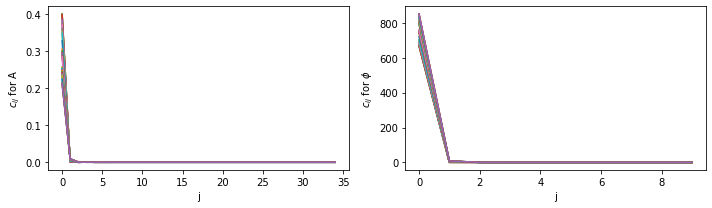

In [ ]:

plt.subplot(1, 2, 1)
[plt.plot(rb_A_coeffs[j]) for j in range(rb_A.size)];
plt.xlabel('j')
plt.ylabel('$c_{ij}$ for A')

plt.subplot(1, 2, 2)
[plt.plot(rb_phi_coeffs[j]) for j in range(rb_A.size)];
plt.xlabel('j')
plt.ylabel('$c_{ij}$ for $\phi$')

plt.tight_layout()
plt.show()

For each basis function $e_j$ we can plot the coefficients $c_{ij}$ as a function of $q_i$. 

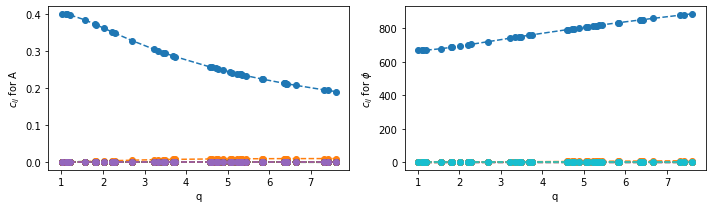

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(lambda_values, rb_A_coeffs[:,j],'--o') for j in range(rb_A.size)];
plt.xlabel('q')
plt.ylabel('$c_{ij}$ for A')

plt.subplot(1, 2, 2)
[plt.plot(lambda_values, rb_phi_coeffs[:,j],'--o') for j in range(rb_phi.size)];
plt.xlabel('q')
plt.ylabel('$c_{ij}$ for $\phi$')

plt.tight_layout()
plt.show()

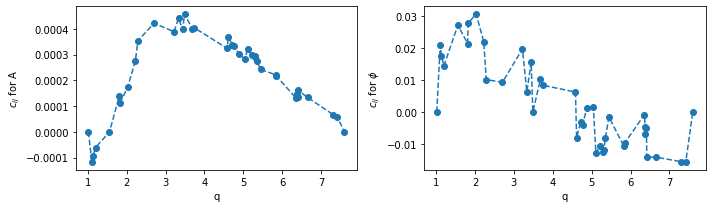

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lambda_values, rb_A_coeffs[:,3], '--o')
plt.xlabel('q')
plt.ylabel('$c_{ij}$ for A')

plt.subplot(1, 2, 2)
plt.plot(lambda_values, rb_phi_coeffs[:,3], '--o') 
plt.xlabel('q')
plt.ylabel('$c_{ij}$ for $\phi$')

plt.tight_layout()
plt.show()

We can reconstruct each waveform $q_i$ by computing the expansion $\sum_{j=1}^{m} c_{ij} e_{j}(t)$ for $A$ and $\phi$. For example, for the waveform with $q=q_2$:

In [ ]:
reconstructed_A = np.zeros(len(times_trim))
for j in range(rb_A.size):
  reconstructed_A += rb_A_coeffs[2,j]*rb_A.basis[j]

reconstructed_phi = np.zeros(len(times_trim))
for j in range(rb_phi.size):
  reconstructed_phi += rb_phi_coeffs[2,j]*rb_phi.basis[j]

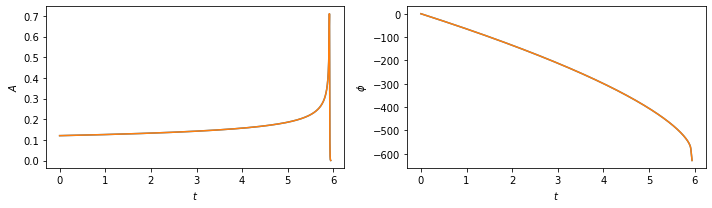

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(times_trim,reconstructed_A);
plt.plot(times_trim,A_ro[2]);
plt.xlabel('$t$')
plt.ylabel('$A$')

plt.subplot(1, 2, 2)
plt.plot(times_trim,reconstructed_phi);
plt.plot(times_trim,phi_ro[2]);
plt.xlabel('$t$')
plt.ylabel('$\phi$')

plt.tight_layout()
plt.show()


Here we show the relative diference between the original waveform and the reconstructed waveform.

<ipython-input-56-de18319bf1ea>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(times_trim,(reconstructed_phi-phi_ro[2])/phi_ro[2]);


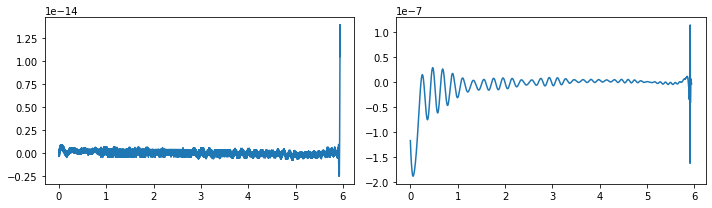

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(times_trim,(reconstructed_A-A_ro[2])/A_ro[2]);

plt.subplot(1, 2, 2)
plt.plot(times_trim,(reconstructed_phi-phi_ro[2])/phi_ro[2]);

plt.tight_layout()
plt.show()

The same reconstruction is obtained directly by rompy's project function:

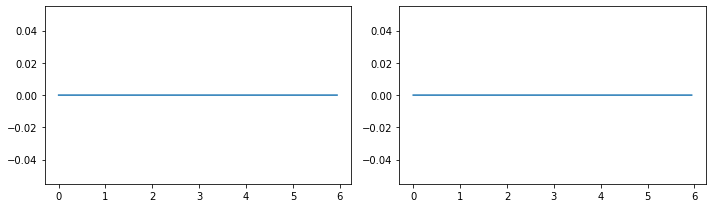

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(times_trim, reconstructed_A - rb_A.project(A_ro[2]));

plt.subplot(1, 2, 2)
plt.plot(times_trim, reconstructed_phi - rb_phi.project(phi_ro[2]));

plt.tight_layout()
plt.show()

For each waveform, we can compute the overall mismatch with its reconstruction. The mismatch is practically zero for all the waveforms that correspond to the greedy points and at the requested error level of for the remaining waveforms in the training sample. Using a denser training sample reduces the mismatch for those remaining waveforms.

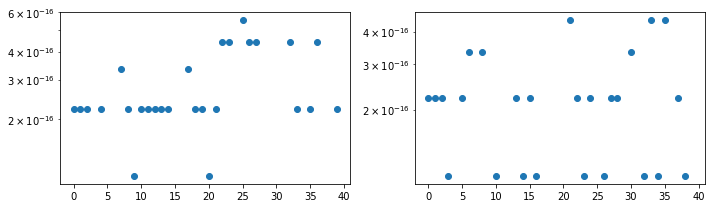

In [ ]:
mismatch_A = [integration_A.mismatch(A_ro[i], rb_A.project(A_ro[i])) for i in range(lambda_values.shape[0])]
mismatch_phi = [integration_phi.mismatch(phi_ro[i], rb_phi.project(phi_ro[i])) for i in range(lambda_values.shape[0])]

plt.subplot(1, 2, 1)
plt.semilogy(np.abs(mismatch_A), 'o');

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(mismatch_phi), 'o');

plt.tight_layout()
plt.show()

###Generate a random validation set and evaluate the mismatch when projected onto the reduced-order basis.

In [ ]:
nsample = 40
q_min = 1.0
q_max = 8.0
spin1z = 0.0
spin2z = 0.0
f_lower = 8.0
amplitude_scaling = 1e18

lambda_values_validation, hp_ro_pycbc_validation, hc_ro_pycbc_validation = training_set_generator(Mtot, nsample, \
                                                  q_min, q_max, spin1z, spin2z, f_lower, delta_t_init, \
                                                  amplitude_scaling, sampling = "random", verbose=True)

  2%|▎         | 1/40 [00:00<00:38,  1.00it/s]

length of h is 45208


  5%|▌         | 2/40 [00:02<00:38,  1.02s/it]

length of h is 46205


  8%|▊         | 3/40 [00:03<00:38,  1.03s/it]

length of h is 46765


 10%|█         | 4/40 [00:04<00:38,  1.06s/it]

length of h is 50098


 12%|█▎        | 5/40 [00:05<00:37,  1.07s/it]

length of h is 50423


 15%|█▌        | 6/40 [00:06<00:37,  1.09s/it]

length of h is 51708


 18%|█▊        | 7/40 [00:07<00:36,  1.11s/it]

length of h is 52228


 20%|██        | 8/40 [00:09<00:40,  1.27s/it]

length of h is 53438


 22%|██▎       | 9/40 [00:10<00:39,  1.26s/it]

length of h is 54554


 25%|██▌       | 10/40 [00:11<00:36,  1.22s/it]

length of h is 55244


 28%|██▊       | 11/40 [00:12<00:34,  1.20s/it]

length of h is 56051


 30%|███       | 12/40 [00:13<00:33,  1.20s/it]

length of h is 58344


 32%|███▎      | 13/40 [00:15<00:32,  1.19s/it]

length of h is 60306


 35%|███▌      | 14/40 [00:16<00:31,  1.20s/it]

length of h is 62998


 38%|███▊      | 15/40 [00:17<00:30,  1.22s/it]

length of h is 66156


 40%|████      | 16/40 [00:18<00:30,  1.25s/it]

length of h is 69970


 42%|████▎     | 17/40 [00:20<00:31,  1.38s/it]

length of h is 70464


 45%|████▌     | 18/40 [00:22<00:32,  1.46s/it]

length of h is 71742


 48%|████▊     | 19/40 [00:23<00:31,  1.50s/it]

length of h is 71993


 50%|█████     | 20/40 [00:25<00:29,  1.45s/it]

length of h is 72345


 52%|█████▎    | 21/40 [00:26<00:27,  1.43s/it]

length of h is 73813


 55%|█████▌    | 22/40 [00:27<00:25,  1.41s/it]

length of h is 75551


 57%|█████▊    | 23/40 [00:29<00:23,  1.41s/it]

length of h is 75870


 60%|██████    | 24/40 [00:30<00:22,  1.41s/it]

length of h is 76903


 62%|██████▎   | 25/40 [00:32<00:22,  1.48s/it]

length of h is 78358


 65%|██████▌   | 26/40 [00:34<00:23,  1.67s/it]

length of h is 83196


 68%|██████▊   | 27/40 [00:35<00:20,  1.61s/it]

length of h is 83955


 70%|███████   | 28/40 [00:37<00:19,  1.59s/it]

length of h is 87280


 72%|███████▎  | 29/40 [00:39<00:17,  1.59s/it]

length of h is 88967


 75%|███████▌  | 30/40 [00:40<00:15,  1.60s/it]

length of h is 90005


 78%|███████▊  | 31/40 [00:42<00:14,  1.60s/it]

length of h is 91286


 80%|████████  | 32/40 [00:43<00:12,  1.62s/it]

length of h is 92318


 82%|████████▎ | 33/40 [00:46<00:12,  1.82s/it]

length of h is 96818


 85%|████████▌ | 34/40 [00:47<00:10,  1.78s/it]

length of h is 97527


 88%|████████▊ | 35/40 [00:49<00:08,  1.75s/it]

length of h is 97835


 90%|█████████ | 36/40 [00:51<00:06,  1.74s/it]

length of h is 99716


 92%|█████████▎| 37/40 [00:53<00:05,  1.76s/it]

length of h is 106919


 95%|█████████▌| 38/40 [00:54<00:03,  1.77s/it]

length of h is 106932


 98%|█████████▊| 39/40 [00:57<00:01,  1.93s/it]

length of h is 107334


100%|██████████| 40/40 [00:59<00:00,  1.48s/it]

length of h is 108114


In [ ]:
times_vd, hp_co_0pad_vd = common_time_grid(hp_ro_pycbc_validation, dt=delta_t_init)
times_vd, hc_co_0pad_vd = common_time_grid(hc_ro_pycbc_validation, dt=delta_t_init)

del hp_ro_pycbc_validation, hc_ro_pycbc_validation

A_co_0pad_vd = np.sqrt(hp_co_0pad_vd**2 + hc_co_0pad_vd**2)
phi_co_0pad_vd = np.arctan2(-hc_co_0pad_vd, hp_co_0pad_vd)

del hp_co_0pad_vd, hc_co_0pad_vd

temp = phi_co_0pad_vd[:,0]
phi_co_0pad_unwrap_vd = np.unwrap(temp)

for i in range(1,lambda_values_validation.shape[0]):
  temp = phi_co_0pad_vd[:,i]
  temp_unwrap = np.unwrap(temp)
  phi_co_0pad_unwrap_vd = (np.column_stack((phi_co_0pad_unwrap_vd,temp_unwrap)))

time_align_vd, A_co_aligned_vd, phi_co_aligned_vd = align_A_phi(times_vd, A_co_0pad_vd, phi_co_0pad_unwrap_vd, delta_t_init)
display(time_align_vd)

del A_co_0pad_vd, phi_co_0pad_vd, phi_co_0pad_unwrap_vd

time_start_vd = time_align_vd - int(20000*Mtot*TIME/delta_t_init) 
time_trim_vd = int(time_align_vd + 100*Mtot*TIME/delta_t_init)
time_align_trim_vd = time_align_vd - time_start_vd
time_end_vd = int(time_align_trim_vd + 100*Mtot*TIME/delta_t_init)

A_co_aligned_trim_vd =  A_co_aligned_vd[time_start_vd:time_trim_vd,]
phi_co_aligned_trim_vd =  phi_co_aligned_vd[time_start_vd:time_trim_vd,]
times_trim_vd = times[time_start_vd:time_trim_vd]
times_trim_vd = times_trim_vd - times_trim_vd[0]

del A_co_aligned_vd, phi_co_aligned_vd

phi_co_aligned_trim_vshift_vd = phi_co_aligned_trim_vd[:,0] - phi_co_aligned_trim_vd[0,0]

for i in range(1,lambda_values_validation.shape[0]):
  temp = phi_co_aligned_trim_vd[:,i] - phi_co_aligned_trim_vd[0,i]
  phi_co_aligned_trim_vshift_vd = (np.column_stack((phi_co_aligned_trim_vshift_vd,temp)))

del phi_co_aligned_trim_vd

A_ro_vd = A_co_aligned_trim_vd.transpose()
phi_ro_vd = phi_co_aligned_trim_vshift_vd.transpose()

del A_co_aligned_trim_vd, phi_co_aligned_trim_vshift_vd 

#A_ro_vd = A_ro_vd/A_ro_vd[0]  #scale amplitude by first waveform


[44737, 45735, 46296, 49629, 49954, 51240, 51760, 52970, 54086, 54776, 55583, 57876, 59838, 62531, 65689, 69504, 69998, 71275, 71527, 71879, 73347, 75086, 75405, 76437, 77892, 82730, 83490, 86815, 88502, 89540, 90821, 91853, 96353, 97062, 97371, 99252, 106455, 106468, 106870, 107650]


44737

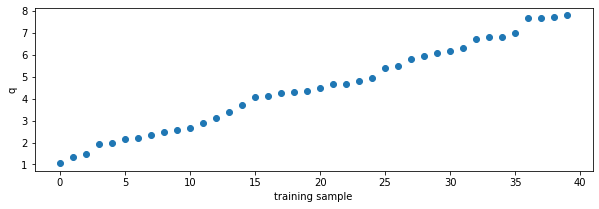

In [ ]:
plt.plot(lambda_values_validation,'o');
plt.xlabel('training sample')
plt.ylabel('q')
plt.show()

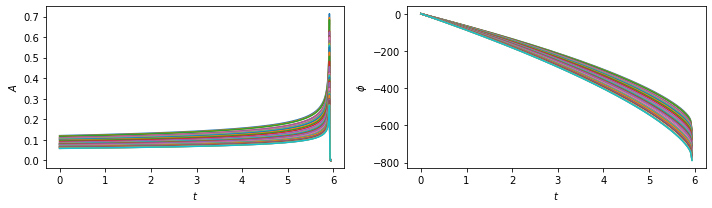

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim_vd, A_ro_vd[i]) for i in range(lambda_values_validation.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')

plt.subplot(1, 2, 2)
[plt.plot(times_trim_vd,phi_ro_vd[i]) for i in range(lambda_values_validation.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$\phi$')

plt.tight_layout()
plt.show()

In [ ]:
display(len(times_trim_vd), len(times_trim))
diff_len = len(times_trim_vd) - len(times_trim)

24338

24338

In [ ]:
A_ro_vd_trim = np.delete(A_ro_vd, np.s_[0:diff_len:1], 1)
phi_ro_vd_trim_tmp = np.delete(phi_ro_vd, np.s_[0:diff_len:1], 1)

phi_co_vd_trim = phi_ro_vd_trim_tmp.transpose()

phi_co_vd_trim_vshift = phi_co_vd_trim[:,0] - phi_co_vd_trim[0,0]

for i in range(1,lambda_values_validation.shape[0]):
  temp = phi_co_vd_trim[:,i] - phi_co_vd_trim[0,i]
  phi_co_vd_trim_vshift = (np.column_stack((phi_co_vd_trim_vshift,temp)))

phi_ro_vd_trim = phi_co_vd_trim_vshift.transpose()

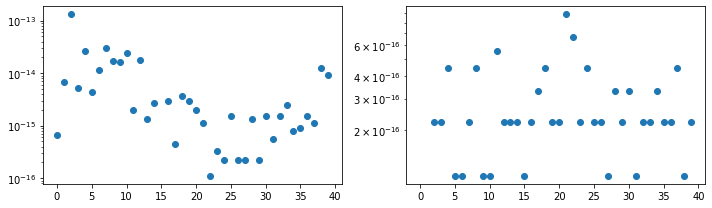

In [ ]:
mismatch_A_vd = [integration_A.mismatch(A_ro_vd_trim[i], rb_A.project(A_ro_vd_trim[i])) \
                                               for i in range(lambda_values_validation.shape[0])]

mismatch_phi_vd = [integration_phi.mismatch(phi_ro_vd_trim[i], rb_phi.project(phi_ro_vd_trim[i])) \
                                               for i in range(lambda_values_validation.shape[0])]
plt.subplot(1, 2, 1)
plt.semilogy(np.abs(mismatch_A_vd), 'o');

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(mismatch_phi_vd), 'o');

plt.tight_layout()
plt.show()

###Empirical interpolation

Given the reduced-order basis, we compute the empirical interpolation nodes $T_k$ ($k=1,\ldots,m$) for $A$ and for $\phi$

In [ ]:
eim_A = rp.EmpiricalInterpolant(rb_A.basis, verbose=True)
eim_phi = rp.EmpiricalInterpolant(rb_phi.basis, verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 24217)
(2, '\t', 23533)
(3, '\t', 24233)
(4, '\t', 24251)
(5, '\t', 24225)
(6, '\t', 24129)
(7, '\t', 24202)
(8, '\t', 24212)
(9, '\t', 24185)
(10, '\t', 2610)
(11, '\t', 24216)
(12, '\t', 24241)
(13, '\t', 2179)
(14, '\t', 24215)
(15, '\t', 24218)
(16, '\t', 24208)
(17, '\t', 8166)
(18, '\t', 14342)
(19, '\t', 20588)
(20, '\t', 18234)
(21, '\t', 105)
(22, '\t', 24221)
(23, '\t', 9862)
(24, '\t', 16685)
(25, '\t', 4812)
(26, '\t', 1572)
(27, '\t', 13876)
(28, '\t', 22230)
(29, '\t', 11471)
(30, '\t', 19188)
(31, '\t', 16264)
(32, '\t', 5386)
(33, '\t', 23977)
(34, '\t', 21659)
(35, '\t', 303)
('\nStep', '\t', 'Nodes')
(1, '\t', 24337)
(2, '\t', 22635)
(3, '\t', 24211)
(4, '\t', 24102)
(5, '\t', 24240)
(6, '\t', 14630)
(7, '\t', 24194)
(8, '\t', 24263)
(9, '\t', 24217)
(10, '\t', 23673)


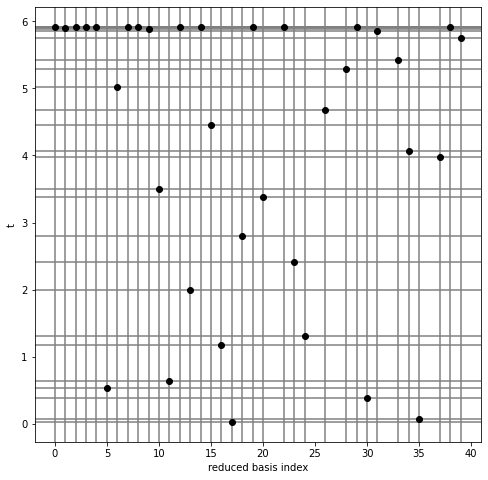

In [ ]:
fig2 = plt.figure(2, [8,8])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in rb_A.indices]
[ax2.axhline(y=xx, color='gray') for xx in times_trim[eim_A.indices]]
ax2.plot(rb_A.indices, times_trim[eim_A.indices], 'ko');
ax2.set_xlabel('reduced basis index');
ax2.set_ylabel('t');
plt.show()

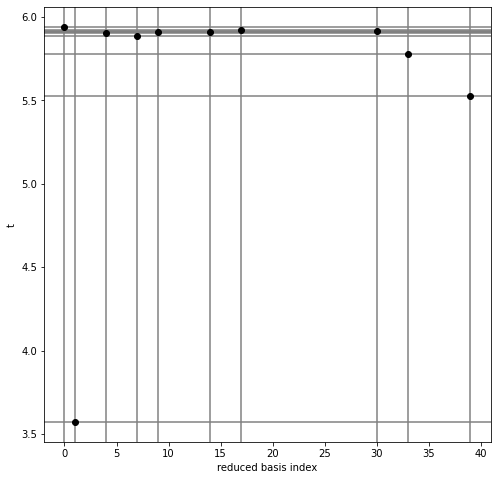

In [ ]:
fig2 = plt.figure(2, [8,8])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in rb_phi.indices]
[ax2.axhline(y=xx, color='gray') for xx in times_trim[eim_phi.indices]]
ax2.plot(rb_phi.indices, times_trim[eim_phi.indices], 'ko');
ax2.set_xlabel('reduced basis index');
ax2.set_ylabel('t');
plt.show()

The waveforms in the training set can be reconstructed using the EIM basis. For example, for the 6th waveform:

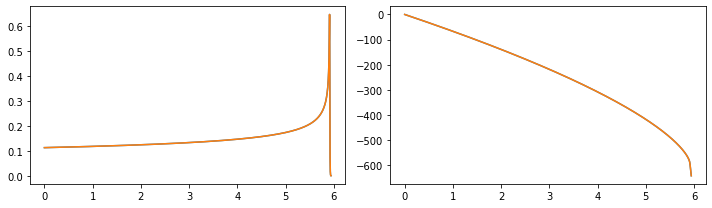

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(times_trim, A_ro[5], label='first')
plt.plot(times_trim, eim_A.interpolate(A_ro[5]), label='last')

plt.subplot(1, 2, 2)
plt.plot(times_trim, phi_ro[5], label='first')
plt.plot(times_trim, eim_phi.interpolate(phi_ro[5]), label='last')

plt.tight_layout()
plt.show() 

We can compute the mismatch between the original training set and the reconstructed through the EIM basis.

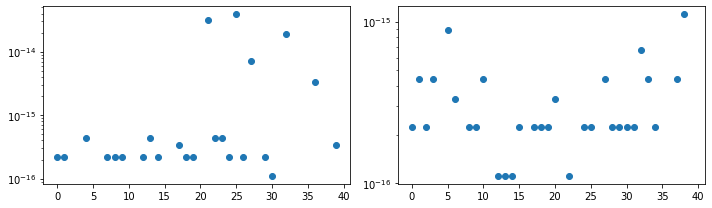

In [ ]:
plt.subplot(1, 2, 1)
plt.semilogy(np.abs([integration_A.mismatch(A_ro[ii], eim_A.interpolate(A_ro[ii])) \
                                               for ii in range(lambda_values.shape[0])]), 'o');
                                              
plt.subplot(1, 2, 2)
plt.semilogy(np.abs([integration_phi.mismatch(phi_ro[ii], eim_phi.interpolate(phi_ro[ii])) \
                                               for ii in range(lambda_values.shape[0])]), 'o');
plt.tight_layout()
plt.show()                              

Compute mismatch for validation set.

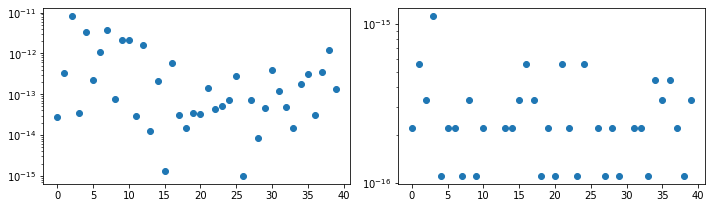

In [ ]:
plt.subplot(1, 2, 1)
plt.semilogy(np.abs([integration_A.mismatch(A_ro_vd_trim[ii], eim_A.interpolate(A_ro_vd_trim[ii])) \
                                               for ii in range(lambda_values_validation.shape[0])]), 'o');
                                              
plt.subplot(1, 2, 2)
plt.semilogy(np.abs([integration_phi.mismatch(phi_ro_vd_trim[ii], eim_phi.interpolate(phi_ro_vd_trim[ii])) \
                                               for ii in range(lambda_values_validation.shape[0])]), 'o');
plt.tight_layout()
plt.show()  

### Construct EIM coefficient matrix

In order to construct the coefficient matrix of the EIM expansion, we first need to sort the indices of the reduced basis and the indices of the EIM time nodes in ascending order.

In [ ]:
rb_A_indices_sorted = np.sort(rb_A.indices)
display(rb_A_indices_sorted)

eim_A_indices_sorted = np.sort(eim_A.indices)
display(eim_A_indices_sorted)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35, 37, 38,
       39], dtype=int32)

array([  105,   303,  1572,  2179,  2610,  4812,  5386,  8166,  9862,
       11471, 13876, 14342, 16264, 16685, 18234, 19188, 20588, 21659,
       22230, 23533, 23977, 24129, 24185, 24202, 24208, 24212, 24215,
       24216, 24217, 24218, 24221, 24225, 24233, 24241, 24251],
      dtype=int32)

In [ ]:
rb_phi_indices_sorted = np.sort(rb_phi.indices)
display(rb_phi_indices_sorted)

eim_phi_indices_sorted = np.sort(eim_phi.indices)
display(eim_phi_indices_sorted)

array([ 0,  1,  4,  7,  9, 14, 17, 30, 33, 39], dtype=int32)

array([14630, 22635, 23673, 24102, 24194, 24211, 24217, 24240, 24263,
       24337], dtype=int32)

Now we can construct the matrix of coefficients $a_{ik}= h(T_k;Q_i)$.

First, construct a matrix, where each row is one of the waveforms in the training set that corresponds to a greedy point.

In [ ]:
A_ro_greedy = A_ro[rb_A_indices_sorted,:]
phi_ro_greedy = phi_ro[rb_phi_indices_sorted,:]


In [ ]:
display(A_ro_greedy.shape)
display(phi_ro_greedy.shape)

(35, 24338)

(10, 24338)

Next, select the subset of this matrix, that is evaluated only at the empirical time nodes $T_k$.

In [ ]:
a_ik_A = A_ro_greedy[:,eim_A_indices_sorted]
a_ik_phi = phi_ro_greedy[:,eim_phi_indices_sorted]

In [ ]:
display(a_ik_A.shape)
display(a_ik_phi.shape)

(35, 35)

(10, 10)

Selecting specific columns (i.e. specific times $T_k$) we obtain 1-D lists $\alpha_k$ that depend on $Q_i$. These can then be fitted to produce interpolating functions $\hat \alpha_k$.

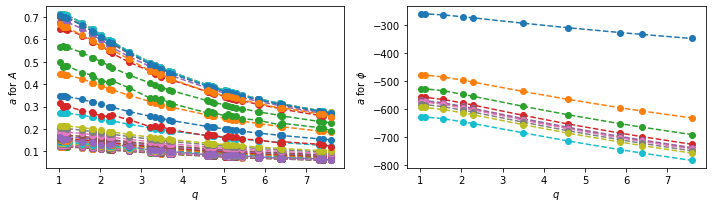

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(lambda_values[rb_A_indices_sorted], a_ik_A[:,k], '--o') for k in range(eim_A.indices.shape[0])];
plt.xlabel('$q$')
plt.ylabel('$a$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(lambda_values[rb_phi_indices_sorted], a_ik_phi[:,k],  '--o') for k in range(eim_phi.indices.shape[0])];
plt.xlabel('$q$')
plt.ylabel('$a$ for $\phi$')

plt.tight_layout()
plt.show() 

Repeat, but for all waveforms in the training set:

In [ ]:
a_ik_A_all = A_ro[:,eim_A_indices_sorted]
a_ik_phi_all = phi_ro[:,eim_phi_indices_sorted]

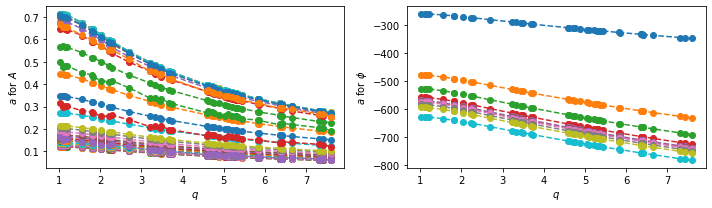

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(lambda_values, a_ik_A_all[:,k], '--o') for k in range(eim_A.indices.shape[0])];
plt.xlabel('$q$')
plt.ylabel('$a$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(lambda_values, a_ik_phi_all[:,k],  '--o') for k in range(eim_phi.indices.shape[0])];
plt.xlabel('$q$')
plt.ylabel('$a$ for $\phi$')

plt.tight_layout()
plt.show() 

###Construct the EIM basis $B_k(t)$.

First, find the order in which the ROM basis functions were selected, then re-order the basis functions, so that they correspond to ascending order in $q$.

In [ ]:
rb_A_sorted_order =np.argsort(rb_A.indices) 
rb_phi_sorted_order =np.argsort(rb_phi.indices) 

In [ ]:
rb_A_basis_sorted = rb_A.basis[rb_A_sorted_order]
rb_phi_basis_sorted = rb_phi.basis[rb_phi_sorted_order]


Construct a matrix, where each row is one of the basis functions $e_j$ of the ROM basis.

In [ ]:
ej_A_basis_ro = []
for basis in rb_A_basis_sorted:
  ej_A_basis_ro.append(basis)

ej_A_basis_ro=np.asarray(ej_A_basis_ro)

ej_phi_basis_ro = []
for basis in rb_phi_basis_sorted:
  ej_phi_basis_ro.append(basis)

ej_phi_basis_ro=np.asarray(ej_phi_basis_ro)

Next, select the subset of this matrix, that is evaluated only at the empirical time nodes $T_k$.

In [ ]:
Vkj_A_ro = ej_A_basis_ro[:,eim_A_indices_sorted]
Vkj_phi_ro = ej_phi_basis_ro[:,eim_phi_indices_sorted]

Compute the inverse matrix.

In [ ]:
Vkj_A_ro_INV = np.linalg.inv(Vkj_A_ro)
Vkj_phi_ro_INV = np.linalg.inv(Vkj_phi_ro)

Compute the EIM basis functions $B_k(t)$ (each row is one basis function).

In [ ]:
eim_A_basis = Vkj_A_ro_INV.dot(rb_A_basis_sorted)
eim_phi_basis = Vkj_phi_ro_INV.dot(rb_phi_basis_sorted)

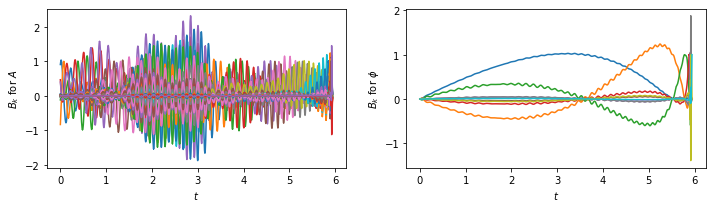

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim, eim_A_basis[k]) for k in range(eim_A.indices.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$B_k$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(times_trim, eim_phi_basis[k]) for k in range(eim_phi.indices.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$B_k$ for $\phi$')

plt.tight_layout()
plt.show()

###Reconstruct the waveforms in the training set, using the EIM basis.

In [ ]:
A_reconstruct =a_ik_A_all.dot(eim_A_basis)
phi_reconstruct =a_ik_phi_all.dot(eim_phi_basis)

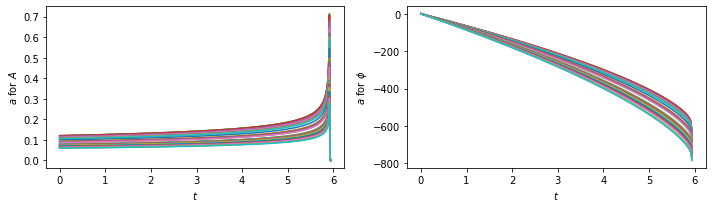

In [ ]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim, A_reconstruct[k]) for k in range(A_reconstruct.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$a$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(times_trim, phi_reconstruct[k]) for k in range(phi_reconstruct.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$a$ for $\phi$')


plt.tight_layout()
plt.show()

Relative difference between the reconstructed and original waveforms.

<ipython-input-90-68dd140dfa54>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(times_trim,(phi_reconstruct[3]-phi_ro[3])/phi_ro[3]);


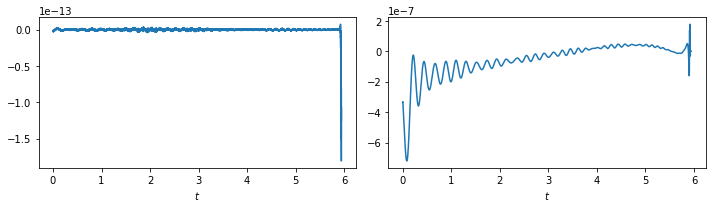

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(times_trim,(A_reconstruct[3]-A_ro[3])/A_ro[3]);
plt.xlabel('$t$')

plt.subplot(1, 2, 2)
plt.plot(times_trim,(phi_reconstruct[3]-phi_ro[3])/phi_ro[3]);
plt.xlabel('$t$')

plt.tight_layout()
plt.show()

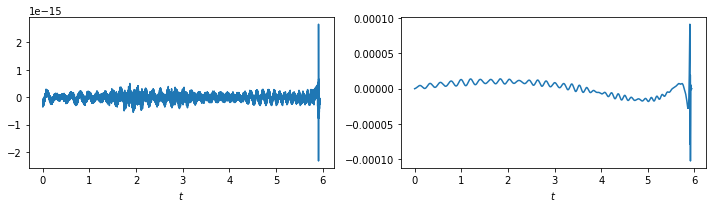

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(times_trim,(A_reconstruct[3]-A_ro[3]));
plt.xlabel('$t$')

plt.subplot(1, 2, 2)
plt.plot(times_trim,(phi_reconstruct[3]-phi_ro[3]));
plt.xlabel('$t$')

plt.tight_layout()
plt.show()

In [ ]:
integration_A.mismatch(A_ro[3], A_reconstruct[3])

0.0

Mismatch for all waveforms (we basically obtain the same results as with Rompy's *interpolate* routine).

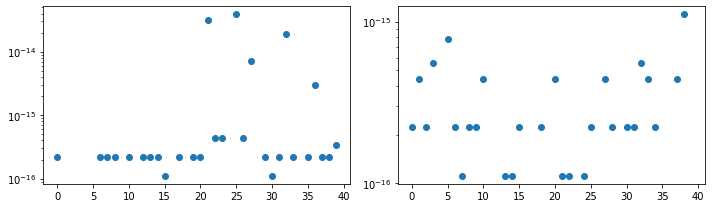

In [ ]:
mismatch_A_eim = [integration_A.mismatch(A_ro[i], A_reconstruct[i]) for i in range(A_reconstruct.shape[0])]
mismatch_phi_eim = [integration_phi.mismatch(phi_ro[i], phi_reconstruct[i]) for i in range(phi_reconstruct.shape[0])]

plt.subplot(1, 2, 1)
plt.semilogy(np.abs(mismatch_A_eim), 'o');

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(mismatch_phi_eim), 'o');

plt.tight_layout()
plt.show()

Reconstructing the original waveforms:

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


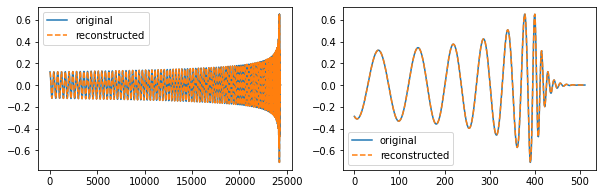

In [ ]:
w_ro = A_ro * np.exp(1j * phi_ro)
w_reconstruct = A_reconstruct * np.exp(1j * phi_reconstruct)

plt.subplot(1, 2, 1)
plt.plot(w_ro[0], label='original')
plt.plot(w_reconstruct[0], '--', label='reconstructed')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(w_ro[0][-512:], label='original')
plt.plot(w_reconstruct[0][-512:], '--', label='reconstructed')
plt.legend()

###Timings

In [ ]:
m1, m2 = Mq_to_m1m2(60.0, lambda_values[0])
chi1 = 0
chi2 = 0
delta_t = delta_t=delta_t_init
%timeit -n3 -r3 hp, hc = get_td_waveform(approximant='SEOBNRv4', mass1=m1, mass2=m2, \
                                         spin1z=chi1, spin2z=chi2, \
                                         delta_t=delta_t, \
                                         f_lower=8.0, \
                                         mode_array=[[2, 2]])

%timeit -n3 -r3 eim_A.interpolate(A_ro[0])

1.07 s ± 84.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
297 µs ± 158 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [ ]:
display(times_trim.size, lambda_values.shape[0], eim_A.size, rb_A.size )
print(float(times_trim.size*lambda_values.shape[0])/(eim_A.size*rb_A.size))


24338

40

35

35

794.7102040816327
